In [33]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.feature import hog,local_binary_pattern
import glob
import numpy as np
from sklearn import svm
from skimage import feature
from sklearn.metrics import classification_report
from skimage.color import rgb2gray

import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate


from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [19]:
path_to_directory = 'C:/Users/karth/OneDrive/Desktop/UN5550/UN5550 LAB/fingerprint-spoof-detection'

# Change the current working directory to the specified path
os.chdir(path_to_directory)

In [45]:
# import training data
live_train = glob.glob('data/Spoof_data/train_live/live/*.png') #positive
spoof_train = glob.glob('data/Spoof_data/train_spoof/Training Biometrika Spoof/spoof/*.png') # negative

# import testing data
live_test = glob.glob('data/Spoof_data/test_live/live/*.png') # positive
spoof_test = glob.glob('data/Spoof_data/test_spoof/Testing Biometrika Spoof/spoof/*.png') # negative

In [46]:
print(len(spoof_test))

200


In [47]:
spoof_train

['data/Spoof_data/train_spoof/Training Biometrika Spoof/spoof\\10_1.png',
 'data/Spoof_data/train_spoof/Training Biometrika Spoof/spoof\\10_10.png',
 'data/Spoof_data/train_spoof/Training Biometrika Spoof/spoof\\10_2.png',
 'data/Spoof_data/train_spoof/Training Biometrika Spoof/spoof\\10_3.png',
 'data/Spoof_data/train_spoof/Training Biometrika Spoof/spoof\\10_4.png',
 'data/Spoof_data/train_spoof/Training Biometrika Spoof/spoof\\10_5.png',
 'data/Spoof_data/train_spoof/Training Biometrika Spoof/spoof\\10_6.png',
 'data/Spoof_data/train_spoof/Training Biometrika Spoof/spoof\\10_7.png',
 'data/Spoof_data/train_spoof/Training Biometrika Spoof/spoof\\10_8.png',
 'data/Spoof_data/train_spoof/Training Biometrika Spoof/spoof\\10_9.png',
 'data/Spoof_data/train_spoof/Training Biometrika Spoof/spoof\\112_1.png',
 'data/Spoof_data/train_spoof/Training Biometrika Spoof/spoof\\112_10.png',
 'data/Spoof_data/train_spoof/Training Biometrika Spoof/spoof\\112_2.png',
 'data/Spoof_data/train_spoof/Tra

In [48]:
# initialize empty lists to append data
live_train_images = []
spoof_train_images = []
live_test_images = []
spoof_test_images = []

# read images from given path and append to the variavles
for path in live_train: live_train_images.append(imread(path))
for path in spoof_train: spoof_train_images.append(imread(path))
for path in live_test: live_test_images.append(imread(path))
for path in spoof_test: spoof_test_images.append(imread(path))

In [49]:
# convert images to np arrays
live_train_images, spoof_train_images = np.asarray(live_train_images), np.asarray(spoof_train_images)
live_test_images, spoof_test_images = np.asarray(live_test_images), np.asarray(spoof_test_images)

In [50]:
# change the type of feature you want to use here
feature_type = "lbp" #hog or lbp

# initialize empty lists to append features
live_train_features, spoof_train_features = [], []
live_test_features, spoof_test_features = [], []

if(feature_type == "hog"):
    
    # calculate and store hog features of training data
    for live_img, spoof_img in zip(live_train_images, spoof_train_images):
        live_train_features.append(hog(live_img, feature_vector = True))
        spoof_train_features.append(hog(spoof_img, feature_vector = True))
    
    # calculate and store hog features of testing data
    for live_img, spoof_img in zip(live_test_images, spoof_test_images):
        live_test_features.append(hog(live_img, feature_vector = True))
        spoof_test_features.append(hog(spoof_img, feature_vector = True))
        
if(feature_type == "lbp"):

# parameters copied from scikit docs of lbp
    METHOD = 'uniform'
    R = 3
    P = 8 * R

    # calculate and store lbp features of training data
    for live_img, spoof_img in zip(live_train_images, spoof_train_images):
        live_img = rgb2gray(live_img)
        spoof_img = rgb2gray(spoof_img)
        live_train_features.append(local_binary_pattern(live_img, P, R, METHOD).flatten())
        spoof_train_features.append(local_binary_pattern(spoof_img, P, R, METHOD).flatten())
    
    # calculate and store lbp features of training data   
    for live_img, spoof_img in zip(live_test_images, spoof_test_images):
        # convert rgb to gray
        live_img = rgb2gray(live_img)
        # convert rgb to gray
        spoof_img = rgb2gray(spoof_img)
        live_test_features.append(local_binary_pattern(live_img, P, R, METHOD).flatten())
        spoof_test_features.append(local_binary_pattern(spoof_img, P, R, METHOD).flatten())

C:\Users\karth\anaconda3\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [51]:
# define labels 1 for live and 0 for spoof
# i.e. create a list of 200 1's and 200 0's 
labels_train = [[1]]*len(live_train_features) + [[0]]*len(spoof_train_features)

# merge both positive and negative training data
full_train = live_train_features + spoof_train_features

# assign labels for all test data, 1 for positive, 0 for negative
labels_test = [[1]]*len(live_test_features) + [[0]]*len(spoof_test_features)

# merge both positive and negative training data
full_test = live_test_features + spoof_test_features

In [52]:
len(labels_train)

400

In [53]:
print(len(spoof_train))

207


In [54]:
features_train = np.array(full_train)
features_test = np.array(full_test)

# stack features and labels together
data_frame_train = np.hstack((features_train,labels_train))

# shuffle train data
np.random.shuffle(data_frame_train)

In [55]:
# split features and labels of train data
x_train = data_frame_train[:len(data_frame_train),:-1]
y_train = data_frame_train[:len(data_frame_train),-1]

# ready test data and labels
x_test = features_test
y_test = labels_test

In [56]:
dt = DecisionTreeClassifier()

dt.fit(x_train, y_train)

# Make predictions on the testing data
y_dt = dt.predict(x_test)

print(classification_report(y_test, y_dt))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.48      0.91      0.63       200

    accuracy                           0.46       400
   macro avg       0.24      0.46      0.31       400
weighted avg       0.24      0.46      0.31       400



In [57]:
svm_classifier = SVC(kernel='linear')

# Train the classifier on the training data
svm_classifier.fit(x_train, y_train)

# Make predictions on the testing data
y_svm = svm_classifier.predict(x_test)

print(classification_report(y_test, y_svm))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       200
           1       0.98      0.93      0.95       200

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



In [58]:
logistic_regression = LogisticRegression(max_iter=1000)

# Train the classifier on the training data
logistic_regression.fit(x_train, y_train)

# Make predictions on the testing data
y_lr = logistic_regression.predict(x_test)

print(classification_report(y_test, y_lr))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       200
           1       0.98      0.92      0.95       200

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



In [59]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
random_forest_classifier.fit(x_train, y_train)

# Make predictions on the testing data
y_rf = random_forest_classifier.predict(x_test)

print(classification_report(y_test, y_rf))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       200
           1       0.86      0.90      0.88       200

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



In [60]:
naive_bayes_classifier = GaussianNB()

# Train the classifier on the training data
naive_bayes_classifier.fit(x_train, y_train)

# Make predictions on the testing data
y_nb = naive_bayes_classifier.predict(x_test)

print(classification_report(y_test, y_nb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.49      0.98      0.66       200

    accuracy                           0.49       400
   macro avg       0.25      0.49      0.33       400
weighted avg       0.25      0.49      0.33       400



In [61]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier on the training data
knn_classifier.fit(x_train, y_train)

# Make predictions on the testing data
y_knn = knn_classifier.predict(x_test)

print(classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           0       1.00      0.14      0.25       200
           1       0.54      1.00      0.70       200

    accuracy                           0.57       400
   macro avg       0.77      0.57      0.48       400
weighted avg       0.77      0.57      0.48       400



In [62]:
results = {}
scores_dt = cross_validate(dt, x_test, y_test, cv = 5, scoring = ['accuracy', 'precision', 'recall', 'f1'])

results[0] = {
        'Model': 'Decision Tree',
        'Accuracy': scores_dt['test_accuracy'].mean(),
        'Precision': scores_dt['test_precision'].mean(),
        'Recall': scores_dt['test_recall'].mean(),
        'F1 Score': scores_dt['test_f1'].mean()
    }

#print(results)


In [63]:
scores_svm = cross_validate(svm_classifier, x_test, y_test, cv=5, scoring= ['accuracy', 'precision', 'recall', 'f1'])

results[1] = {
        'Model': 'SVM',
        'Accuracy': scores_svm['test_accuracy'].mean(),
        'Precision': scores_svm['test_precision'].mean(),
        'Recall': scores_svm['test_recall'].mean(),
        'F1 Score': scores_svm['test_f1'].mean()
    }

#print()results

C:\Users\karth\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [64]:
scores_lr = cross_validate(logistic_regression, x_test, y_test, cv=5, scoring = ['accuracy', 'precision', 'recall', 'f1'])

results[2] = {
        'Model': 'Logistic Regression',
        'Accuracy': scores_lr['test_accuracy'].mean(),
        'Precision': scores_lr['test_precision'].mean(),
        'Recall': scores_lr['test_recall'].mean(),
        'F1 Score': scores_lr['test_f1'].mean()
    }

#print(results)

C:\Users\karth\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [65]:
scores_rf = cross_validate(random_forest_classifier, x_test, y_test, cv = 5, scoring = ['accuracy', 'precision', 'recall', 'f1'])

results[3] = {
        'Model': 'Random Forest',
        'Accuracy': scores_rf['test_accuracy'].mean(),
        'Precision': scores_rf['test_precision'].mean(),
        'Recall': scores_rf['test_recall'].mean(),
        'F1 Score': scores_rf['test_f1'].mean()
    }

#print(results)

C:\Users\karth\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

In [66]:
scores_nb = cross_validate(naive_bayes_classifier, x_test, y_test, cv=5, scoring = ['accuracy', 'precision', 'recall', 'f1'])

results[4] = {
        'Model': 'Naive Bayes',
        'Accuracy': scores_nb['test_accuracy'].mean(),
        'Precision': scores_nb['test_precision'].mean(),
        'Recall': scores_nb['test_recall'].mean(),
        'F1 Score': scores_nb['test_f1'].mean()
    }

#print(results)

C:\Users\karth\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [67]:
scores_knn = cross_validate(knn_classifier, x_test, y_test, cv = 5, scoring = ['accuracy', 'precision', 'recall', 'f1'])

results[5] = {
        'Model': 'KNN',
        'Accuracy': scores_knn['test_accuracy'].mean(),
        'Precision': scores_knn['test_precision'].mean(),
        'Recall': scores_knn['test_recall'].mean(),
        'F1 Score': scores_knn['test_f1'].mean()
    }

#print(results)

C:\Users\karth\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\karth\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

In [72]:
import pandas as pd
import seaborn as sns

In [73]:
results_df = pd.DataFrame(results)
results_df = results_df.T

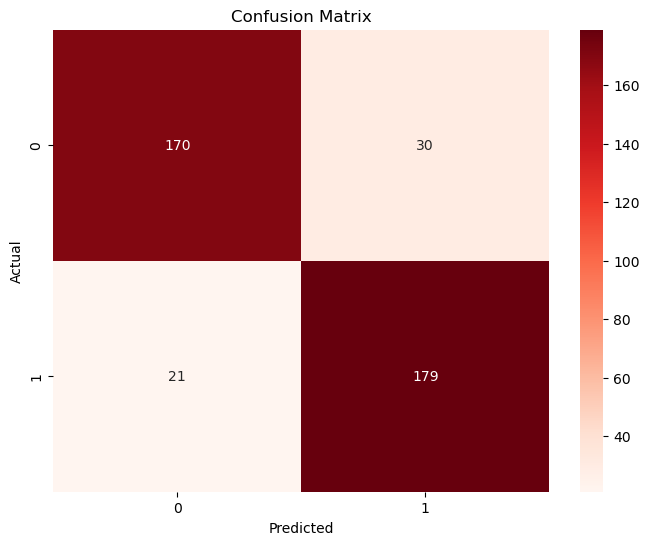

In [79]:
conf_matrix = confusion_matrix(y_test, y_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()